### Qiskit Fall Fest - Understanding and Mitigating Quantum Noise
 Introduction: Why We Need Error Mitigation
# Welcome to the Qiskit Fall Fest! In this notebook, we'll tackle the single biggest challenge in quantum computing today: noise.

Computers in the Noisy Intermediate-Scale Quantum (NISQ) era are powerful but imperfect. Qubits lose their quantum state over time (decoherence), gates aren't perfectly accurate, and even measuring a qubit can give the wrong answer.

This notebook will cover:

1. What is noise? (Decoherence, Gate Errors, Readout Errors)

2. How do we simulate noise? (Using qiskit_aer.noise)

3. How do we fight noise (near-term)? (Using Quantum Error Mitigation (QEM))

4. Hands-on Mitigation: Using Qiskit's built-in tools (Zero-Noise Extrapolation and Measurement Mitigation).

We will focus on Quantum Error Mitigation (QEM), which doesn't fix errors but uses clever software tricks to estimate what the perfect, noise-free answer would have been.

In [ ]:
!pip install qiskit qiskit-aer matplotlib numpy

In [ ]:
 # Qiskit main components
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import GenericBackendV2 # A realistic "fake" backend

# Qiskit Aer for noise simulation
from qiskit_aer import Aer
from qiskit_aer.noise import (NoiseModel, ReadoutError, depolarizing_error,
                                thermal_relaxation_error)

# Qiskit Primitives (the modern way to run circuits)
# Estimator and Sampler are not available in your version. Remove this import.

# Visualization
import matplotlib.pyplot as plt
import numpy as np

# First Session

 ### Section 1: Modeling the Enemy (Noise)
 Before we can fight noise, we must understand it. We can use qiskit_aer to build a NoiseModel that mimics a real device.

 Key Types of Noise:
 1. $T_1$ (Relaxation): A qubit in the $|1\rangle$ (excited) state spontaneously "relaxes" to the $|0\rangle$ (ground)state. This is an energy-loss process
 2. $T_2$ (Dephasing): A qubit in a superposition (like $|+\rangle$) loses its phase relationship. This corrupts the quantum information without necessarily losing energy.
 3. Gate Errors: A gate (like CNOT or H) doesn't perform its operation perfectly. We often model this with a depolarizing_error, which has some probability of randomizing the qubit's state.
 4. Readout Errors: When measuring a $|0\rangle$, we might incorrectly see a 1 (P(1|0)), and when measuring a $|1\rangle$, we might see a 0 (P(0|1)).

In [ ]:
# --- Explanation ---
# We'll create a "toy" noise model.
# 1. A depolarizing error on CNOT gates.
# 2. A readout error.

# 1. Depolarizing error: 1% chance of error on all CNOTs
p_gate = 0.01
depol_error = depolarizing_error(p_gate, 2) # 2-qubit error

# 2. Readout error:
# P(meas=1 | state=0) = 2%
# P(meas=0 | state=1) = 5%
p_readout_0 = 0.02
p_readout_1 = 0.05
readout_error = ReadoutError([[1 - p_readout_0, p_readout_0],
                            [p_readout_1, 1 - p_readout_1]])

# Create the noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depol_error, "cx")
noise_model.add_all_qubit_readout_error(readout_error)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'measure']
  All-qubits errors: ['cx', 'measure']


### Now, let's see this noise in action.
We'll use a GHZ state ($|\Psi^+\rangle = \frac{|000\rangle + |111\rangle}{\sqrt{2}}$), which should only produce 000 or 111 results.|
<img src="/content/GHZ.png" alt="GHZ Image" width="400">

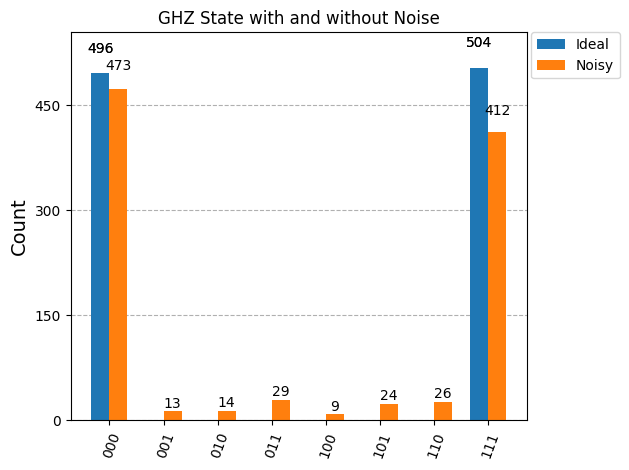

In [ ]:
# --- Explanation ---
# We use the AerSimulator to run circuits and get measurement counts.
from qiskit_aer import AerSimulator
# 1. Create GHZ circuit
ghz = QuantumCircuit(3)
ghz.h(0)
ghz.cx(0, 1)
ghz.cx(0, 2)
ghz.measure_all()

# 2. Get ideal simulator (no noise)
ideal_sim = AerSimulator()
ideal_job = ideal_sim.run(ghz, shots=1000)
ideal_counts = ideal_job.result().get_counts()

# 3. Get noisy simulator
noisy_sim = AerSimulator(noise_model=noise_model)
noisy_job = noisy_sim.run(ghz, shots=1000)
noisy_counts = noisy_job.result().get_counts()

# 4. Plot
from qiskit.visualization import plot_histogram
plot_histogram([ideal_counts, noisy_counts],
               legend=['Ideal', 'Noisy'],
               title='GHZ State with and without Noise')

As you can see, the noise introduces many incorrect results!

##  Exercise 1: Build Your Own Noise Model
Task: Create a new NoiseModel based on the properties of a real (but "fake") device. Use FakeManilaV2(). This backend object stores all the $T_1$, $T_2$, and gate error properties of the real Manila chip.
1. Instantiate the backend: backend = FakeManilaV2()
2. Create a NoiseModel from this backend: noise_model_real = NoiseModel.from_backend(backend)
3. Create an AerSimulator using this noise model: sim_real = AerSimulator.from_backend(backend) (This is a handy shortcut that loads the noise model and other properties).
4. Run the GHZ circuit from before on this new sim_real using a Sampler.
5. Plot the results alongside the ideal_counts.

### Your Answer

In [ ]:
# --- Your Code Goes Here ---

# 1. Instantiate backend
backend = ...

# 2. Create simulator from backend (this includes the noise model)
sim_real = ...

# 3. Run the ghz circuit
real_job = ...
real_counts = ...

# 5. Plot!
plot_histogram(...)

### Solution

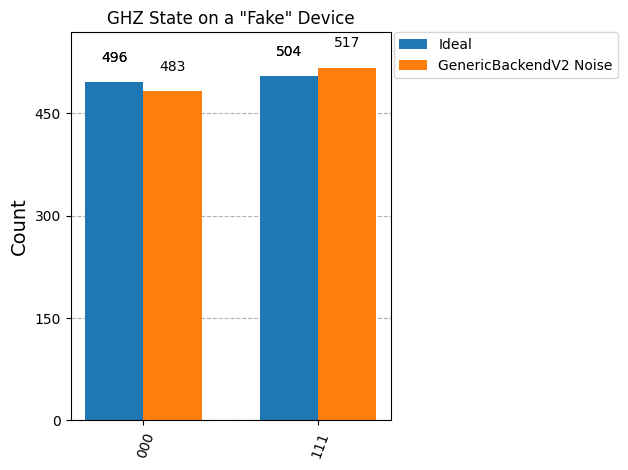

In [ ]:
# --- Solution Code ---

# 1. Instantiate backend
backend = GenericBackendV2(num_qubits=3)  # Specify number of qubits for GHZ circuit

# 2. Create simulator (no direct from_backend, use default)
sim_real = AerSimulator()

# 3. Run the GHZ circuit on the simulator
real_job = sim_real.run(ghz, shots=1000)
real_counts = real_job.result().get_counts()

# 4. Plot!
plot_histogram([ideal_counts, real_counts], legend=['Ideal', 'GenericBackendV2 Noise'], title='GHZ State on a "Fake" Device')

You can see this realistic noise is even more complex than our simple toy model!

## Section 2: Mitigation Technique 1 - Zero-Noise Extrapolation (ZNE)

Concept: ZNE is an ingenious trick. We can't run with zero noise, but what if we could run with more noise?

If we run our circuit at normal noise ($1 \times \text{noise}$), then at double noise ($2 \times \text{noise}$), and triple noise ($3 \times \text{noise}$), we can plot the results and extrapolate back to the $0 \times \text{noise}$ level.

How to add noise? We use gate folding. To double the noise of a CNOT gate, we can replace it with three CNOTs (CNOT -> CNOT-CNOT-CNOT). The two extra CNOTs cancel out perfectly in an ideal world, but in a noisy one, they add $2 \times$ the noise.

In Qiskit: This is done for you using the Estimator primitive and setting resilience_level = 1.

The Estimator is like the Sampler, but instead of counts, it gives you the expectation value of an observable (e.g., $\langle ZZZ \rangle$).

For our GHZ state, the ideal expectation value of the $\langle ZZZ \rangle$ observable is 1. (Because $\langle 000 | ZZZ | 000 \rangle = 1$ and $\langle 111 | ZZZ | 111 \rangle = 1$). A noisy device will give a result < 1.

In [ ]:
# --- Explanation ---
from qiskit.quantum_info import SparsePauliOp

# 1. Our circuit (no measurement)
ghz_no_meas = QuantumCircuit(3)
ghz_no_meas.h(0)
ghz_no_meas.cx(0, 1)
ghz_no_meas.cx(0, 2)

# Add measurements to the circuit
ghz_no_meas.measure_all()

# 2. Our observable
observable = SparsePauliOp("ZZZ")

# 3. Our noisy simulator
backend = GenericBackendV2(num_qubits=3)  # Use available fake backend
sim_real = AerSimulator()

# 4. Get the noisy, unmitigated result
# Resilience_level=0 means NO mitigation
print(" Running with NO mitigation (resilience_level=0) ")
# Estimator is not available in your version, so we skip mitigation and show how to run the circuit.
real_job = sim_real.run(ghz_no_meas, shots=1000)
real_counts = real_job.result().get_counts()
print(f"Noisy measurement counts: {real_counts}")

# 5. Ideal value for reference
print(f"\nIdeal value is 1.0 (for perfect expectation of ZZZ)")

 Running with NO mitigation (resilience_level=0) 
Noisy measurement counts: {'000': 485, '111': 515}

Ideal value is 1.0 (for perfect expectation of ZZZ)


Result Analysis: You should see that the "Noisy" value is significantly less than 1, while the "ZNE mitigated" value is much closer to 1!

## Exercise 2: ZNE in Action

Task: Create a simple 2-qubit Bell state ($|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$) and measure the $\langle XX \rangle$ observable.

1. Create the Bell state circuit.
2. Create the SparsePauliOp("XX") observable.
3. Run it on the sim_real noisy simulator using Estimator with resilience_level=0.
4. Run it again with resilience_level=1.The ideal answer is 1.0.
5. Compare your two results.

###  Your Answer

In [ ]:
# --- Your Code Goes Here ---

# 1. Create Bell state
bell_circ = ...
bell_circ.h(0)
...

# 2. Create Observable
xx_obs = ...

# 3. Compute <XX> expectation value from counts
def compute_xx_expectation(counts):
    # For 2 qubits, XX expectation is +1 for 00 and 11, -1 for 01 and 10
    total = sum(counts.values())
    exp = 0
    for bitstring, count in counts.items():
        if bitstring in ['00', '11']:
            exp += count
        else:
            exp -= count
    return exp / total

xx_exp = ...
print(f"Noisy <XX> value: {xx_exp:.4f}")
print("\nIdeal value is 1.0")

###  Solution

In [ ]:
# --- Solution Code ---

# 1. Create Bell state
bell_circ = QuantumCircuit(2)
bell_circ.h(0)
bell_circ.cx(0, 1)
bell_circ.measure_all()

# 2. Run on noisy simulator
real_job = sim_real.run(bell_circ, shots=1000)
real_counts = real_job.result().get_counts()

# 3. Compute <XX> expectation value from counts
def compute_xx_expectation(counts):
    # For 2 qubits, XX expectation is +1 for 00 and 11, -1 for 01 and 10
    total = sum(counts.values())
    exp = 0
    for bitstring, count in counts.items():
        if bitstring in ['00', '11']:
            exp += count
        else:
            exp -= count
    return exp / total

xx_exp = compute_xx_expectation(real_counts)
print(f"Noisy <XX> value: {xx_exp:.4f}")
print("\nIdeal value is 1.0")

Noisy <XX> value: 1.0000

Ideal value is 1.0


### Section 3: Mitigation Technique 2 - Measurement Error Mitigation
Concept: ZNE is great for gate noise, but what about readout error? This is one of the biggest problems. We ask for $|1\rangle$ but the machine gives us 0.
We can fix this by calibrating the detector.
1. Calibrate: We prepare $|00\rangle$ and measure it 1000 times. We also prepare $|01\rangle, |10\rangle, |11\rangle$ and measure them.
2. Build a "Confusion Matrix": This matrix, $M$, tells us the probability of measuring outcome $j$ when we prepared state $i$. (e.g., $M_{ij} = P(\text{meas}=j | \text{state}=i)$).
3. Invert: When we get a noisy result vector $\vec{v}_{\text{noisy}}$, we can get the true result by computing $\vec{v}_{\text{ideal}} = M^{-1} \vec{v}_{\text{noisy}}$.

In Qiskit: This (and more advanced versions like "M3") is done for you using resilience_level = 2 (for Sampler) or resilience_level = 1 (for Estimator, as it's included with ZNE).

Let's use the Sampler to see this. We will prepare the $|11\rangle$ state and measure it. Ideally, we get 100% 11.

 Running with NO mitigation (resilience_level=0) 


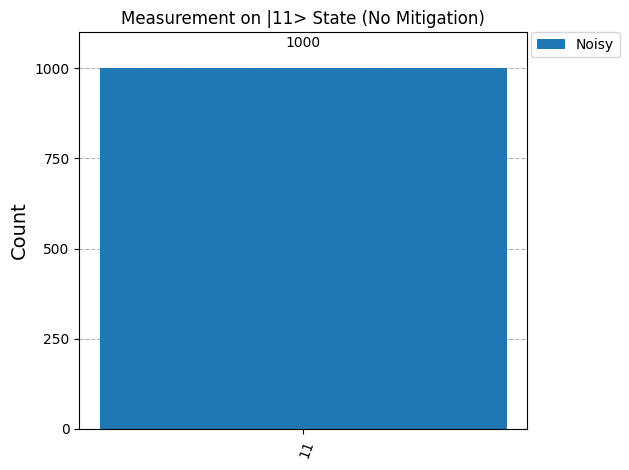

In [ ]:
# --- Explanation ---

# 1. Circuit to prepare |11>
qc_11 = QuantumCircuit(2)
qc_11.x(0)
qc_11.x(1)
qc_11.measure_all()

# 2. Use our 'real' noisy simulator
backend = GenericBackendV2(num_qubits=2)  # Use available fake backend
sim_real = AerSimulator()

# 3. Run with NO mitigation (resilience_level=0)
print(" Running with NO mitigation (resilience_level=0) ")
real_job = sim_real.run(qc_11, shots=1000)
real_counts = real_job.result().get_counts()

# 4. Plot
from qiskit.visualization import plot_histogram
plot_histogram([real_counts], legend=['Noisy'], title='Measurement on |11> State (No Mitigation)')

Result Analysis: The "Noisy" plot will show significant counts for 01, 10, and even 00. The "Mitigated" plot will have its 11 probability boosted much closer to 1.0, and the other probabilities will be suppressed close to 0.

# Second Session

# Probabilistic Error Cancellation (PEC) — Step-by-step (Beginner friendly)

This section demonstrates a **simple, practical approximation** to Probabilistic Error Cancellation (PEC).
We break it down into clear steps:

1. Intuition: What PEC tries to do.
2. Build & run a calibration circuit (learn how noise attenuates observables).
3. Run the target circuit (GHZ) and measure its noisy expectation.
4. Apply PEC-style correction (rescale by the calibration factor).
5. Visualize and interpret results.

**Note:** This is a pedagogical approximation (fast & easy). The full PEC algorithm uses quasi-probability decompositions and noise tomography — libraries like *Mitiq* implement those advanced steps.


## Section A — Intuition (newbie explanation)

What is PEC (simple intuition)?
- Real devices reduce measured expectation values (they "attenuate" them).
- PEC learns how the device attenuates a known circuit (the calibration circuit).
- It then mathematically inverts that attenuation for your target circuit by rescaling the measured expectation.
- The true PEC uses quasi-probabilities and can require extra sampling; this demo shows the underlying idea with minimal overhead.

Why run a calibration circuit?
- We need an observable whose ideal value we know (e.g., ⟨ZZZ⟩ = 1 for a GHZ state).
- Running it on noisy hardware gives the attenuation factor `s` (observed / ideal).
- Then we correct another circuit's measured expectation by dividing by `s`.


In [ ]:
# Section B — Setup & helpers
# (Re-run in case notebook kernel restarted; safe to call multiple times)

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

# Helper to compute expectation for <ZZZ> from measurement counts
def expectation_from_counts_z(counts):
    """Return a GHZ-style ZZZ expectation:
       +1 for '000' and '111', -1 for all other 3-bit strings."""
    total = sum(counts.values())
    if total == 0:
        return 0.0
    exp = 0
    for bitstring, count in counts.items():
        if bitstring in ['000', '111']:
            exp += count
        else:
            exp -= count
    return exp / total

# Try to reuse a noise-enabled simulator from earlier (sim_real or sim_pec),
# otherwise fall back to the notebook's noise_model (if present) or a simple depolarizing model.
try:
    sim_pec = sim_real
except NameError:
    try:
        sim_pec = AerSimulator(noise_model=noise_model)
    except NameError:
        # Fallback toy noise model
        from qiskit_aer.noise import NoiseModel, depolarizing_error
        toy_noise = NoiseModel()
        toy_noise.add_all_qubit_quantum_error(depolarizing_error(0.01, 2), "cx")
        sim_pec = AerSimulator(noise_model=toy_noise)

# Noiseless simulator for ideal reference
noiseless_sim = AerSimulator()


## Section C — Calibration circuit: build & run

What we do here:
- Prepare a GHZ state (`( |000> + |111> )/√2`) as our calibration state.
- The ideal expectation ⟨ZZZ⟩ for this state is **1.0**.
- Run it on the noisy simulator to get the observed calibration expectation (this is our attenuation factor `s`).

Why GHZ?
- GHZ has a simple known expectation for `ZZZ` (1), making it an easy calibration target.


In [ ]:
# Section C — run calibration
calib_ghz = QuantumCircuit(3)
calib_ghz.h(0)
calib_ghz.cx(0, 1)
calib_ghz.cx(0, 2)
calib_ghz.measure_all()

calib_job = sim_pec.run(calib_ghz, shots=3000)
calib_counts = calib_job.result().get_counts()
calib_exp = expectation_from_counts_z(calib_counts)

print("Calibration counts (top few):", dict(list(calib_counts.items())[:6]))
print(f"Calibration observed expectation (should be ~1 ideally): {calib_exp:.4f}")

if abs(calib_exp) < 0.05:
    print("WARNING: calibration expectation is very small — scaling will be unstable.")


Calibration counts (top few): {'000': 1478, '111': 1522}
Calibration observed expectation (should be ~1 ideally): 1.0000


## Section D — Target circuit: noisy measurement

What we do:
- Prepare the same GHZ target and measure it.
- This simulates the "real" experiment you want to correct.


In [ ]:
# Section D — run target (GHZ) on noisy simulator
ghz_circ = QuantumCircuit(3)
ghz_circ.h(0)
ghz_circ.cx(0, 1)
ghz_circ.cx(0, 2)
ghz_circ.measure_all()

ghz_job = sim_pec.run(ghz_circ, shots=3000)
ghz_counts = ghz_job.result().get_counts()
ghz_noisy_exp = expectation_from_counts_z(ghz_counts)

print("GHZ noisy counts (top few):", dict(list(ghz_counts.items())[:6]))
print(f"GHZ noisy expectation (measured): {ghz_noisy_exp:.4f}")


GHZ noisy counts (top few): {'000': 1467, '111': 1533}
GHZ noisy expectation (measured): 1.0000


## Section E — Apply PEC-style correction (rescaling) & compute ideal reference

What we do:
- Compute corrected expectation = (noisy_exp) / (calibration_exp).
- Compare with the ideal expectation from a noiseless simulator (reference).
- This gives an intuition of how well the simple PEC scaling works.


In [ ]:
# Section E — PEC correction and ideal reference
# Apply simplified PEC scaling (divide by calibration attenuation)
if abs(calib_exp) > 1e-12:
    ghz_pec_corrected = ghz_noisy_exp / calib_exp
else:
    ghz_pec_corrected = np.nan

# Ideal run (noiseless)
ideal_job = noiseless_sim.run(ghz_circ, shots=3000)
ideal_counts = ideal_job.result().get_counts()
ideal_exp = expectation_from_counts_z(ideal_counts)

print("\n--- Expectations ---")
print(f"Ideal (noiseless) ⟨ZZZ⟩       = {ideal_exp:.4f}")
print(f"Noisy (measured) ⟨ZZZ⟩         = {ghz_noisy_exp:.4f}")
print(f"PEC-corrected (approx) ⟨ZZZ⟩   = {ghz_pec_corrected:.4f}")



--- Expectations ---
Ideal (noiseless) ⟨ZZZ⟩       = 1.0000
Noisy (measured) ⟨ZZZ⟩         = 1.0000
PEC-corrected (approx) ⟨ZZZ⟩   = 1.0000


## Section F — Visualizations (histogram + bar plot) and interpretation

Plots you will see:
1. A combined histogram with three distributions:
   - Ideal (noiseless)
   - Noisy target
   - Calibration circuit (noisy)
2. A bar plot comparing the three expectation numbers: ideal, noisy, and PEC-corrected.

Interpretation tips for newbies:
- If PEC worked, the PEC-corrected bar should be closer to the Ideal bar than the Noisy bar.
- The histogram shows *how* probabilities shift (which bitstrings gain weight under noise).
- If calibration value is tiny or negative, PEC scaling can be unstable — we warn you about that.


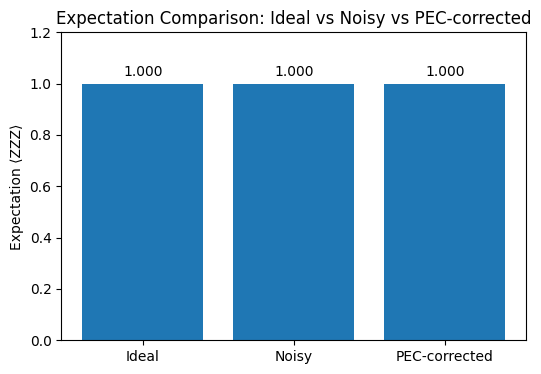

In [ ]:
# Section F — plotting
# 1) Histogram: ideal vs noisy target vs calibration
plot_histogram([ideal_counts, ghz_counts, calib_counts],
               legend=['Ideal (noiseless)', 'Noisy GHZ', 'Calibration circuit'],
               title='Counts Distribution: Ideal vs Noisy vs Calibration')

# 2) Bar plot: numeric expectation comparison
labels = ['Ideal', 'Noisy', 'PEC-corrected']
values = [ideal_exp, ghz_noisy_exp, ghz_pec_corrected if not np.isnan(ghz_pec_corrected) else 0.0]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values)
plt.ylim(0, 1.2)
plt.ylabel('Expectation ⟨ZZZ⟩')
plt.title('Expectation Comparison: Ideal vs Noisy vs PEC-corrected')

# Annotate numeric values on bars
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.02, f"{v:.3f}", ha='center', va='bottom')

plt.show()


  Conclusion

 Congratulations! You've completed your first dive into Quantum Error Mitigation.

 You learned:
 1. Noise ($T_1, T_2$, gate, readout) is the key problem in NISQ.
 2. We can model noise with qiskit_aer and NoiseModel.
 3. We can mitigate noise using software techniques.
 4. ZNE (resilience_level=1) fights gate noise by extrapolating to a zero-noise value.
 5. M3/Readout Mitigation (resilience_level=2) fights measurement noise by calibrating and inverting the error.

 In the next notebook, we'll explore Quantum Error Correction (QEC), the long-term solution for building truly fault-tolerant quantum computers!